# Applying the linear chain trick using AlgebraicPetri.jl

Simon Frost (@sdwfrost), 2023-06-14

## Introduction

This example extends the [basic SIR
model](https://github.com/epirecipes/EpiCats/blob/main/pn_compose_sir/pn_compose_sir.ipynb)
using the linear chain trick (see [this
paper](https://link.springer.com/article/10.1007/s00285-019-01412-w) for
more background), in which we chain together multiple infected stages in
order to change the infectious period distribution.

## Libraries

In [1]:
using AlgebraicPetri,AlgebraicPetri.TypedPetri
using Catlab, Catlab.CategoricalAlgebra, Catlab.Programs
using Catlab.WiringDiagrams
using AlgebraicDynamics.UWDDynam
using LabelledArrays
using OrdinaryDiffEq
using Plots

## Transitions

For convenience, we define `sub`, a function that generate subscripted
variables as strings.

In [2]:
nstages = 4
sub(i::Int) = i<0 ? error("$i is negative") : join('₀'+d for d in reverse(digits(i)))
sub(x::String,i::Int) = x*sub(i);

We define a labelled Petri net that has the different types of
transition in our models. The first argument is an array of state names
as symbols (here, a generic `:Pop`), followed by the transitions in the
model. Transitions are given as
`transition_name=>((input_states)=>(output_states))`.

In [3]:
epi_lpn = LabelledPetriNet(
  [:Pop],
  :infection=>((:Pop, :Pop)=>(:Pop, :Pop)),
  :progression=>(:Pop=>:Pop),
  :recovery=>(:Pop=>:Pop)
);

Next, we define the transmission model as an undirected wiring diagram
using the `@relation` macro, as in the basic SIR example. The steps are
as follows:

1.  Define the undirected wiring diagram.
2.  Convert to an `ACSetTransformation` by composing the wiring diagram
    with the labelled Petri net of transitions.
3.  Extract the composed Petri net from the `ACSetTransformation`.

We use four terms that capture the generation of `I₁` from the four
infectious stages, with a separate `β` parameter for each stage.

In [4]:
si_uwd = @relation (S, I₁, I₂, I₃, I₄) where (S::Pop, I₁::Pop, I₂::Pop, I₃::Pop, I₄::Pop) begin
    infection(S,I₁,I₁,I₁)
    infection(S,I₂,I₁,I₂)
    infection(S,I₃,I₁,I₃)
    infection(S,I₄,I₁,I₄)
end
betas = Symbol.([sub("β",i) for i=1:nstages])
si_acst = oapply_typed(epi_lpn, si_uwd, betas)
si_lpn = dom(si_acst)
Graph(si_lpn)

We repeat for the progression (`I₁` to `I₂`, etc.) and recovery (`I₄` to
`R`) transitions; we will use an indexed parameter `δ` for both the
progression and recovery rates.

In [5]:
ir_uwd = @relation (I₁, I₂, I₃, I₄, R) where (I₁::Pop, I₂::Pop, I₃::Pop, I₄::Pop, R::Pop) begin
    progression(I₁,I₂)
    progression(I₂,I₃)
    progression(I₃,I₄)
    recovery(I₄,R)
end
deltas = Symbol.([sub("δ",i) for i=1:nstages])
ir_acst = oapply_typed(epi_lpn, ir_uwd, deltas)
ir_lpn = dom(ir_acst)
Graph(ir_lpn)

To glue the SI and IR models together to make an SIR model, we perform
the following: 1. We define an undirected wiring diagram which contains
all our states, and two transitions. 2. We then create a
`StructuredMulticospan` using this wiring diagram and a dictionary that
maps the objects in the wiring diagram with the transmission and
recovery Petri nets generated previously. 3. We extract the composed
labelled Petri net.

In [6]:
sir_uwd = @relation (S, I₁, I₂, I₃, I₄, R) where (S::Pop, I₁::Pop, I₂::Pop, I₃::Pop, I₄::Pop, R::Pop) begin
    si(S, I₁, I₂, I₃, I₄)
    ir(I₁, I₂, I₃, I₄, R)
end
sir_smc = oapply(sir_uwd, Dict(
    :si => Open(si_lpn),
    :ir => Open(ir_lpn),
))
sir_lpn = apex(sir_smc)
Graph(sir_lpn)

## Running the model

To run an ODE model from the labelled Petri net, we define a vector
field, the initial conditions, the parameter array, and the time span.

In [7]:
sir_vf = vectorfield(sir_lpn);
u0 = @LArray [990.0, 10.0, 0.0, 0.0, 0.0, 0.0] Tuple(snames(sir_lpn))
p = @LArray vec([repeat([0.5/1000],4); repeat([0.25/4],4)]) Tuple(tnames(sir_lpn))
tspan = (0.0, 40.0);

We can now solve the system.


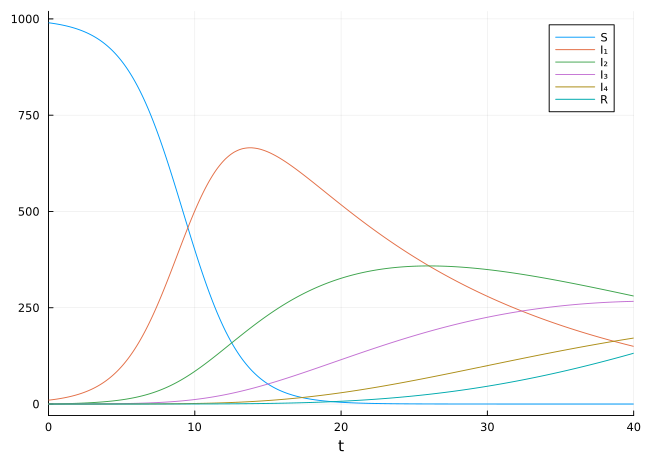

In [8]:
sir_prob = ODEProblem(sir_vf, u0, tspan, p)
sir_sol = solve(sir_prob, Rosenbrock32())
plot(sir_sol)